# Translational Oscillations by a Rotational Actuator (TORA)

In [1]:
using NeuralNetworkAnalysis, MAT
using NeuralNetworkAnalysis: UniformAdditivePostprocessing, SingleEntryVector,
                             NoSplitter

The following option determines whether the verification settings should be
used or not. The verification settings are chosen to show that the safety
property is satisfied. Concretely we split the initial states into small
chunks and run many analyses.

In [2]:
const verification = false;

This model consists of a cart attached to a wall with a spring. The cart is
free to move on a friction-less surface. The car has a weight attached to an
arm, which is free to rotate about an axis. This serves as the control input
to stabilize the cart at $x = 0$.

## Model

The model is four dimensional, given by the following equations:

$$
\left\{ \begin{array}{lcl}
      \dot{x}_1 &=& x_2 \\
      \dot{x}_2 &=& -x_1 + 0.1 \sin(x_3) \\
      \dot{x}_3 &=& x_4  \\
      \dot{x}_4 &=& u
\end{array} \right.
$$

A neural network controller was trained for this system. The trained network
has 3 hidden layers, with 100 neurons in each layer (i.e., a total of 300
neurons). Note that the output of the neural network $f(x)$ needs to be
normalized in order to obtain $u$, namely $u = f(x) - 10$. The sampling time
for this controller is 1s.

In [3]:
@taylorize function TORA!(dx, x, p, t)
    x₁, x₂, x₃, x₄, u = x

    aux = 0.1 * sin(x₃)
    dx[1] = x₂
    dx[2] = -x₁ + aux
    dx[3] = x₄
    dx[4] = u
    dx[5] = zero(u)
    return dx
end

path = @modelpath("Sherlock-Benchmark-9-TORA", "controllerTora.mat")
controller = read_nnet_mat(path, act_key="act_fcns");

## Specification

The verification problem is safety. For an initial set of $x_1 ∈ [0.6, 0.7]$,
$x_2 ∈ [−0.7, −0.6]$, $x_3 ∈ [−0.4, −0.3]$, and $x_4 ∈ [0.5, 0.6]$, the
system has to stay within the box $x ∈ [−2, 2]^4$ for a time window of 20s.

In [4]:
X₀ = Hyperrectangle(low=[0.6, -0.7, -0.4, 0.5], high=[0.7, -0.6, -0.3, 0.6])
U = ZeroSet(1)

vars_idx = Dict(:state_vars=>1:4, :control_vars=>5)
ivp = @ivp(x' = TORA!(x), dim: 5, x(0) ∈ X₀ × U)

period = 1.0  # control period
control_postprocessing = UniformAdditivePostprocessing(-10.0)  # control postprocessing

prob = ControlledPlant(ivp, controller, vars_idx, period;
                       postprocessing=control_postprocessing)

# Safety specification
T = 20.0  # time horizon
T_warmup = 2 * period  # shorter time horizon for dry run
T_reach = verification ? T : T_warmup  # shorter time horizon if not verifying

safe_states = HPolyhedron([HalfSpace(SingleEntryVector(1, 5, 1.0), 2.0),
                           HalfSpace(SingleEntryVector(1, 5, -1.0), 2.0),
                           HalfSpace(SingleEntryVector(2, 5, 1.0), 2.0),
                           HalfSpace(SingleEntryVector(2, 5, -1.0), 2.0),
                           HalfSpace(SingleEntryVector(3, 5, 1.0), 2.0),
                           HalfSpace(SingleEntryVector(3, 5, -1.0), 2.0),
                           HalfSpace(SingleEntryVector(4, 5, 1.0), 2.0),
                           HalfSpace(SingleEntryVector(4, 5, -1.0), 2.0)])
predicate = X -> X ⊆ safe_states;

## Results

In [5]:
alg = TMJets(abstol=1e-10, orderT=8, orderQ=3)
alg_nn = Ai2()
if verification
    splitter = BoxSplitter([4, 4, 3, 5])
else
    splitter = NoSplitter()
end

function benchmark(; T=T, silent::Bool=false)
    # We solve the controlled system:
    silent || println("flowpipe construction")
    res_sol = @timed sol = solve(prob, T=T, alg_nn=alg_nn, alg=alg,
                                 splitter=splitter)
    sol = res_sol.value
    silent || print_timed(res_sol)

    # Next we check the property for an overapproximated flowpipe:
    silent || println("property checking")
    solz = overapproximate(sol, Zonotope)
    res_pred = @timed predicate(solz)
    silent || print_timed(res_pred)
    if res_pred.value
        silent || println("The property is satisfied.")
    else
        silent || println("The property may be violated.")
    end
    return solz
end

benchmark(T=T_warmup, silent=true)  # warm-up
res = @timed benchmark(T=T_reach)  # benchmark
sol = res.value
println("total analysis time")
print_timed(res);

flowpipe construction
  0.559694 seconds (3.76 M allocations: 609.638 MiB, 28.20% gc time)
property checking
  0.000020 seconds (1 allocation: 112 bytes)
The property is satisfied.
total analysis time
  0.581612 seconds (3.91 M allocations: 633.081 MiB, 27.14% gc time)


We also compute some simulations:

In [6]:
import DifferentialEquations

println("simulation")
res = @timed simulate(prob, T=T; trajectories=10, include_vertices=true)
sim = res.value
print_timed(res);

simulation
  2.477663 seconds (3.75 M allocations: 230.310 MiB, 1.68% gc time)


Finally we plot the results

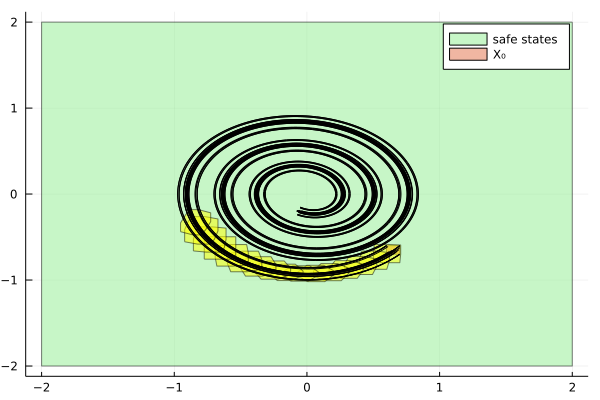

In [7]:
using Plots
import DisplayAs

function plot_helper(fig, vars)
    if vars[1] == 0
        safe_states_projected = project(safe_states, [vars[2]])
        time = Interval(0, T)
        safe_states_projected = cartesian_product(time, safe_states_projected)
    else
        safe_states_projected = project(safe_states, vars)
    end
    plot!(fig, safe_states_projected, color=:lightgreen, lab="safe states")
    if !verification && 0 ∉ vars
        plot!(fig, project(X₀, vars), lab="X₀")
    end
    plot!(fig, sol, vars=vars, color=:yellow, lab="")
    plot_simulation!(fig, sim; vars=vars, color=:black, lab="")
    fig = DisplayAs.Text(DisplayAs.PNG(fig))
end

vars = (1, 2)
fig = plot(xlab="x₁", ylab="x₂")
fig = plot_helper(fig, vars)
# savefig("TORA-x1-x2.png")
fig

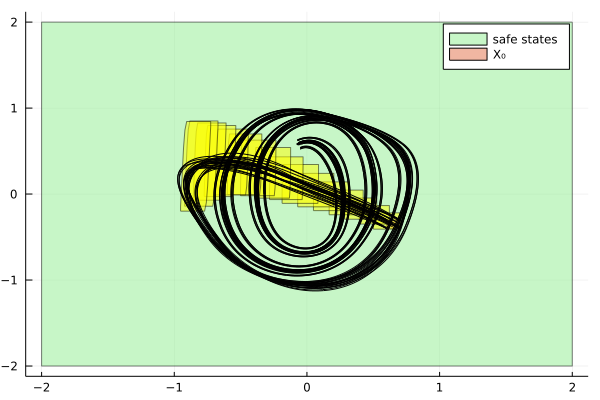

In [8]:
vars = (1, 3)
fig = plot(xlab="x₁", ylab="x₃")
plot_helper(fig, vars)

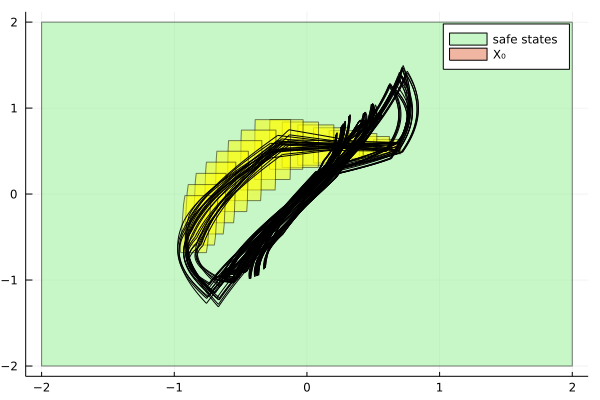

In [9]:
vars = (1, 4)
fig = plot(xlab="x₁", ylab="x₄")
plot_helper(fig, vars)

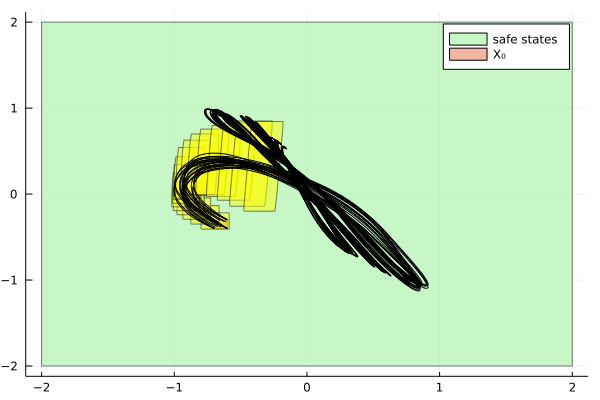

In [10]:
vars=(2, 3)
fig = plot(xlab="x₂", ylab="x₃")
plot_helper(fig, vars)

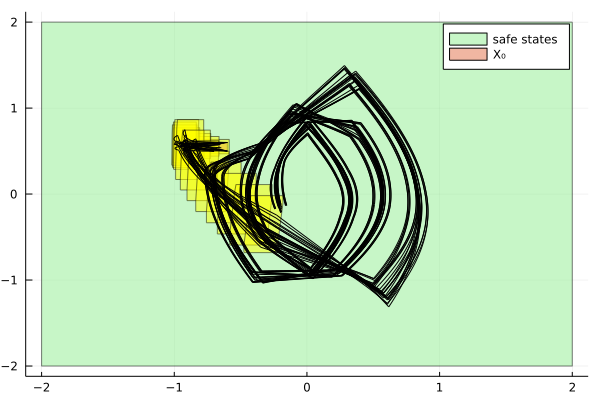

In [11]:
vars=(2, 4)
fig = plot(xlab="x₂", ylab="x₄")
plot_helper(fig, vars)

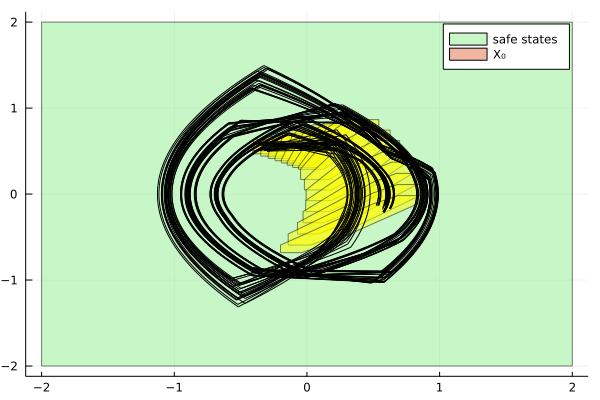

In [12]:
vars=(3, 4)
fig = plot(xlab="x₃", ylab="x₄")
fig = plot_helper(fig, vars)
# savefig("TORA-x3-x4.png")
fig

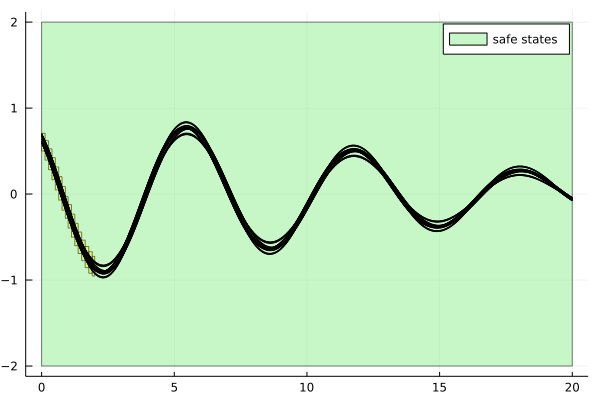

In [13]:
vars = (0, 1)
fig = plot(xlab="t", ylab="x₁")
plot_helper(fig, vars)

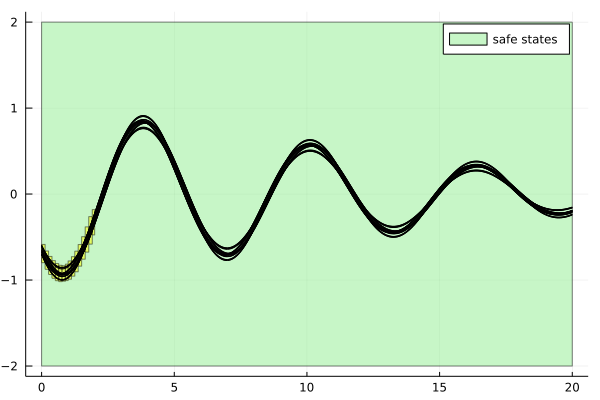

In [14]:
vars=(0, 2)
fig = plot(xlab="t", ylab="x₂")
plot_helper(fig, vars)

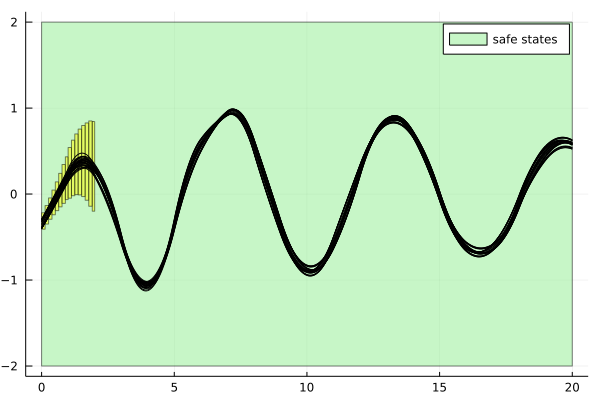

In [15]:
vars=(0, 3)
fig = plot(xlab="t", ylab="x₃")
plot_helper(fig, vars)

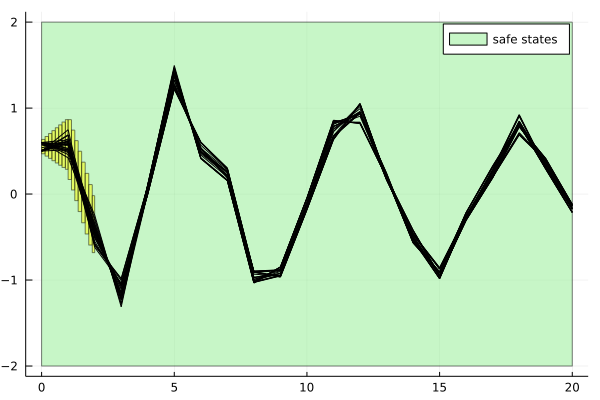

In [16]:
vars=(0, 4)
fig = plot(xlab="t", ylab="x₄")
plot_helper(fig, vars)

Here we plot the control functions for each run:

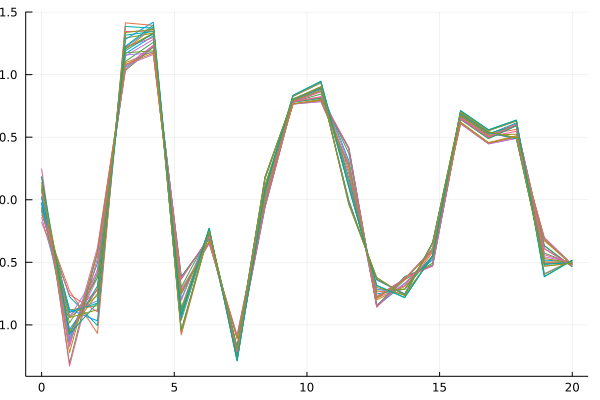

In [17]:
tdom = range(0, 20, length=length(controls(sim, 1)))
fig = plot(xlab="t", ylab="u")
[plot!(fig, tdom, [c[1] for c in controls(sim, i)], lab="") for i in 1:length(sim)]
fig = DisplayAs.Text(DisplayAs.PNG(fig))